<h1 style="text-align: center;">ENERGY CONSUMPTION PREDICTION</h1>
<h1 style="text-align: center;">(PART-1 EDA)</h1>

# 1. About the Topic

## 1.1 Problem Statement

Modern buildings consume a significant portion of global energy, and optimizing this usage is critical for sustainability, cost-efficiency, and environmental impact. However, energy consumption in buildings is highly variable and depends on numerous factors such as building type, weather conditions, occupancy patterns, and time of day.

The problem at hand is to accurately predict hourly energy consumption (electricity, chilled water, steam, hot water) for various buildings across multiple sites using historical meter readings, weather data, and building metadata.

This is formulated as a supervised regression problem where the goal is to forecast future meter readings for unseen data. The solution should generalize well to diverse conditions.

## 1.2 Motivation

- Buildings account for nearly 40% of global energy consumption.

- Reducing energy usage in buildings is key to:
    - Lowering operational costs
    - Reducing carbon emissions
    - Supporting sustainable development

- This project helps in:
    - Identifying high-usage patterns
    - Enabling predictive maintenance
    - Supporting energy-saving policies

## 1.3 Objectives

- Predict future energy usage for buildings accurately.

- Understand how building use, weather, and time affect energy demand.

- Prepare data for ML models using robust preprocessing and feature engineering.

- Select features and models that generalize well to unseen data.

## 1.4 References

[1] **Miller, C., Kathirgamanathan, A., Picchetti, B., Arjunan, P., Park, J. Y., Nagy, Z., Raftery, P., Hobson, B. W., Shi, Z., & Meggers, F.** (2020). The Building Data Genome Project 2, energy meter data from the ASHRAE Great Energy Predictor III competition. arXiv preprint arXiv:2006.02273. https://arxiv.org/abs/2006.02273

[2] **Bünning, F., Huber, B., Schalbetter, A., Aboudonia, A., Hudoba de Badyn, M., Heer, P., Smith, R. S., & Lygeros, J.** (2022). Physics-informed linear regression is competitive with two Machine Learning methods in residential building MPC. arXiv preprint arXiv:2110.15911. https://arxiv.org/abs/2110.15911

[3] **Chen, X., Guo, T., Kriegel, M., & Geyer, P.** (2022). A hybrid-model approach for reducing the performance gap in building energy forecasting. arXiv preprint arXiv:2206.00460. https://arxiv.org/abs/2206.00460

[4] **Zhou, F., Yang, C., & Wang, Z.** (2024). Prediction of building energy consumption for public structures utilizing BIM-DB and RF-LSTM. Energy Reports, 12, 4631–4640. https://doi.org/10.1016/j.egyr.2024.10.044

[5] **Chen, G., Lu, S., Zhou, S., Tian, Z., Kim, M. K., Liu, J., & Liu, X.** (2025). A Systematic Review of Building Energy Consumption Prediction: From Perspectives of Load Classification, Data-Driven Frameworks, and Future Directions. Applied Sciences, 15(6), 3086. https://doi.org/10.3390/app15063086

[6] **ASHRAE - Great Energy Predictor III. (n.d.). Kaggle.** https://www.kaggle.com/competitions/ashrae-energy-prediction/data

# 2. Dataset Description

**train.csv:** 
  1. `building_id` - Foreign key for the building metadata.
  2. `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}.
  3. `timestamp` - Time of measurement
  4. `meter_reading` - The target variable. Energy consumption in kWh (or equivalent).

**test.csv**:
  1. `row_id` - Unique row id
  2. `building_id` - Building id code
  3. `meter` - The meter id code
  4. `timestamp` - Timestamps for the test data period

**building_metadata.csv**
  1. `site_id` - Foreign key for the weather files.
  2. `building_id` - Foreign key for training.csv
  3. `primary_use` - Indicator of the primary category of activities for the building
  4. `square_feet` - Gross floor area of the building
  5. `year_built` - Year building was opened
  6. `floor_count` - Number of floors of the building

**weather_[train/test].csv**:
  1. `site_id` - Foreign key for the weather files.
  2. `timestamp` - Timestamps for the test data period
  3. `air_temperature` - Degrees Celsius
  4. `cloud_coverage` - Portion of the sky covered in clouds
  5. `dew_temperature` - Degrees Celsius
  6. `precip_depth_1_hr` - Precipitation depth (Millimeters)
  7. `sea_level_pressure` - Millibar/hectopascals
  8. `wind_direction` - Compass direction (0-360)
  9. `wind_speed` - Meters per second

# 3. Loading Data

## 3.1 Importing necessary libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive\building_metadata.csv
archive\sample_submission.csv
archive\test.csv
archive\train.csv
archive\weather_test.csv
archive\weather_train.csv


## 3.2 Loading the ASHRAE dataset

In [2]:
data_path = "archive/"

train_path = data_path + "train.csv"
test_path = data_path + "test.csv"

building_path = data_path + "building_metadata.csv"

weather_train_path = data_path + "weather_train.csv"
weather_test_path = data_path + "weather_test.csv"

In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

building_data = pd.read_csv(building_path)

weather_train_data = pd.read_csv(weather_train_path)
weather_test_data = pd.read_csv(weather_test_path)

## 3.3 Viewing Snippets of the dataset

In [4]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
train_data.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [7]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [8]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [9]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [10]:
weather_test_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [11]:
print('Shape of Train Data:',train_data.shape)
print('Shape of Test Data:', test_data.shape)
print('Shape of Building Data:', building_data.shape)
print('Shape of Weather Train Data:', weather_train_data.shape)
print('Shape of Weather Test Data:', weather_test_data.shape)

Shape of Train Data: (20216100, 4)
Shape of Test Data: (41697600, 4)
Shape of Building Data: (1449, 6)
Shape of Weather Train Data: (139773, 9)
Shape of Weather Test Data: (277243, 9)


## 3.4 Converting data to feather format for faster loading

In [13]:
# Converting data into feather format since some dataframes are too large and take a long time to load
# This method is inspired from the kaggle notebook titled: ASHRAE: feather format for fast loading
# Which is found at: https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading

train_data.to_feather('train_data.feather')
test_data.to_feather('test_data.feather')

building_data.to_feather('building_data.feather')

weather_train_data.to_feather('weather_train_data.feather')
weather_test_data.to_feather('weather_test_data.feather')


In [12]:
data_path = "feather_data/"

train_path = data_path + "train_data.feather"
test_path = data_path + "test_data.feather"

building_path = data_path + "building_data.feather"

weather_train_path = data_path + "weather_train_data.feather"
weather_test_path = data_path + "weather_test_data.feather"

In [13]:
train_data = pd.read_feather(train_path)
test_data = pd.read_feather(test_path)

building_data = pd.read_feather(building_path)

weather_train_data = pd.read_feather(weather_train_path)
weather_test_data = pd.read_feather(weather_test_path)

## 3.5 Reducing the memory usage of the data

In [14]:
# This function helps in optimizing the memory used by the dataframes by by modifying/altering the datatype of each column.
# This method is inspired from the kaggle notebook titled: load data (reduce memory usage)
# Which is found at: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df


In [15]:
train_data = reduce_mem_usage(train_data, 'Train Data')
test_data = reduce_mem_usage(test_data, 'Test Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')
weather_test_data = reduce_mem_usage(weather_test_data, 'Weather Test Data')

Memory usage of Train Data is reduced by 71.82 %. Usage dropped from 616.95 MB to 173.84 MB.
Memory usage of Test Data is reduced by 71.82 %. Usage dropped from 1272.51 MB to 358.53 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.
Memory usage of Weather Test Data is reduced by 73.04 %. Usage dropped from 19.04 MB to 5.13 MB.


## 3.6 Merging Data

In [16]:
train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [17]:
test = test_data.merge(building_data, on='building_id', how='left')
test = test.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

In [18]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [19]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [20]:
print('Shape of Combined Train Data:',train.shape)
print('Shape of Combined Test Data:', test.shape)

Shape of Combined Train Data: (20216100, 16)
Shape of Combined Test Data: (41697600, 16)


## 3.7 Breaking Timestamp into Hour, Day, Month, Year

In [21]:
# This function firstly converts timestamp to date and then breaks down date into 6 new columns: hour, day, dayOfWeek, dayOfYear, month and year

def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [22]:
train = breakdown_timestamp(train)
test = breakdown_timestamp(test)

In [23]:
print('New Shape of Train Data:',train.shape)
print('New Shape of Test Data:', test.shape)

New Shape of Train Data: (20216100, 22)
New Shape of Test Data: (41697600, 22)


# 4. EDA

## 4.1 Exploring the Target Value 'Meter Reading'

In [24]:
# This Function Draws the distribution plot for the column passed into the function's arguments

sns.set_theme()

def draw_distribution_graph(dataframe, column_name):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(dataframe[column_name], color='purple', ax = ax).set_title("Distribution Graph for {}".format(column_name), fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

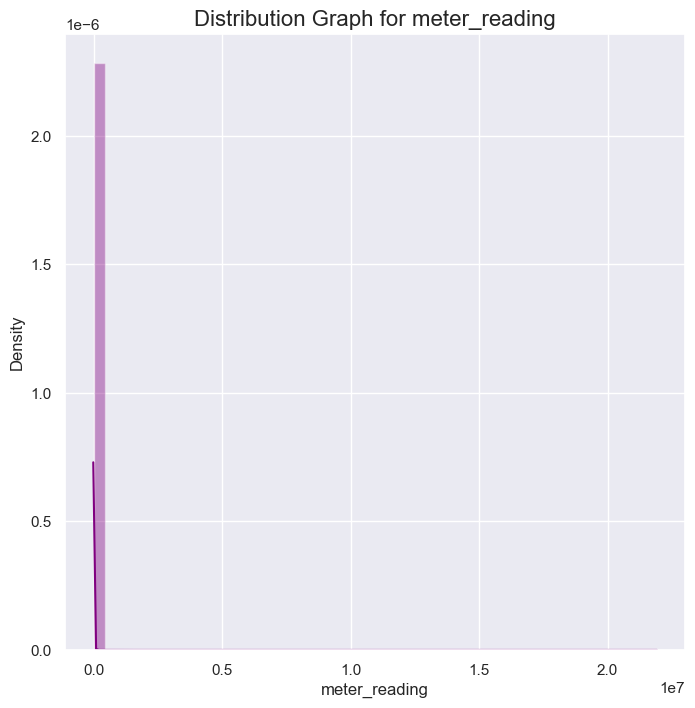

In [25]:
draw_distribution_graph(train, 'meter_reading')

In [26]:
print('Meter Reading has a skewness of', train['meter_reading'].skew())

Meter Reading has a skewness of 104.81131


**Observations:**
1. The Meter Reading is extremely skewed to the left.
2. We need to apply log tranformation to fix the skewness.


In [27]:
train['meter_reading']=np.log1p(train['meter_reading'])

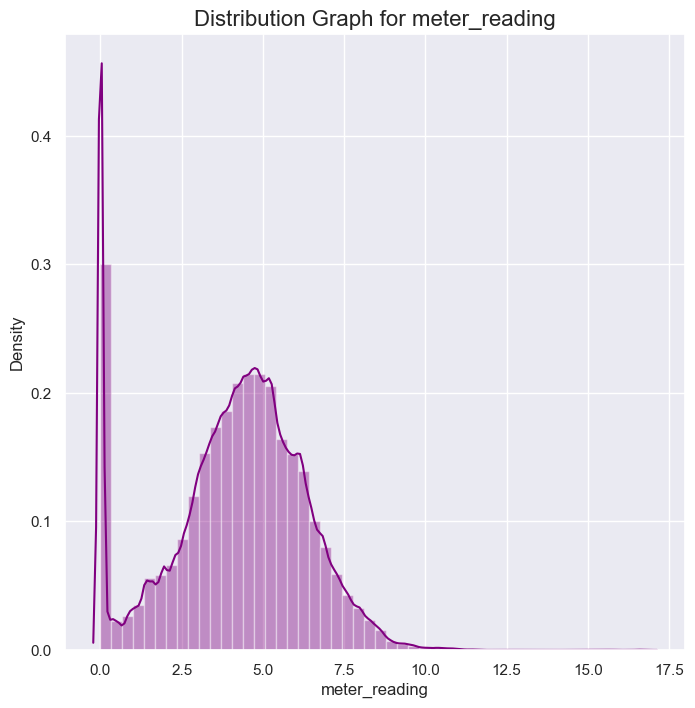

In [28]:
draw_distribution_graph(train, 'meter_reading')

In [29]:
print('Meter Reading has a new skewness of', train['meter_reading'].skew())

Meter Reading has a new skewness of -0.27537704


**Observations:**
- The most recurrent meter reading is zero. (This will be taken care of in the data preperation section)


## 4.2 Exploring Different Meter Types

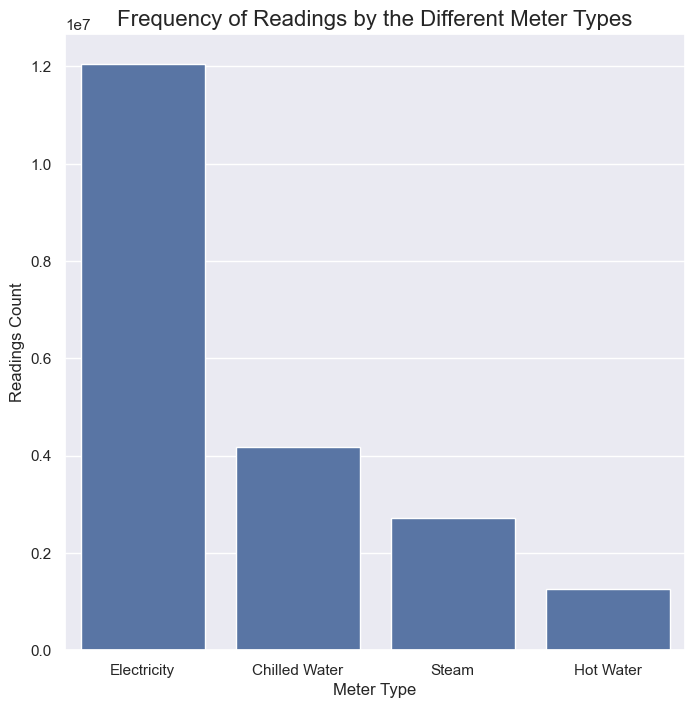

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
meter_types_labels = ['Electricity', 'Chilled Water', 'Steam', 'Hot Water']
sns.countplot(x = 'meter', data = train).set_title("Frequency of Readings by the Different Meter Types", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Meter Type', fontsize=12)
plt.ylabel('Readings Count', fontsize=12)
plt.show()

**Observations:**
1. Electricity meters are the most meters used in buildings. 
2. Hot Water meters are the least used in buildings.


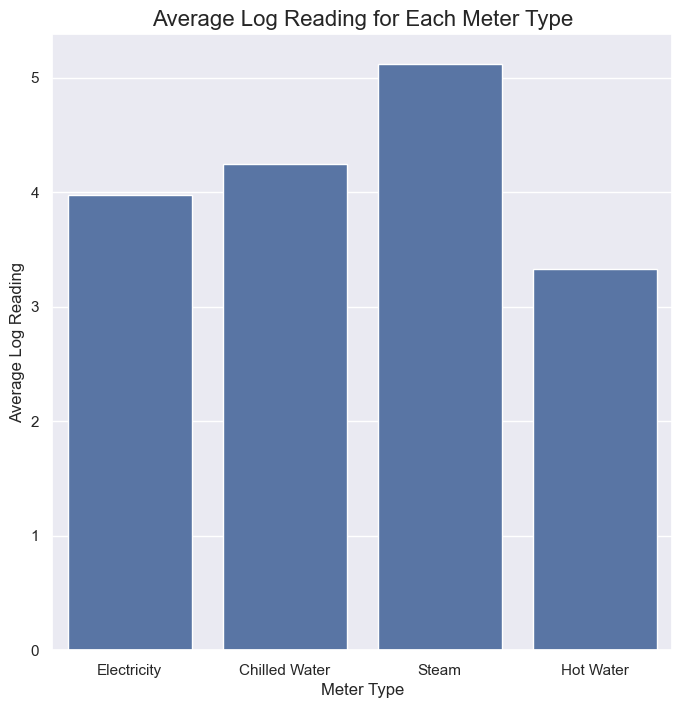

In [31]:
# Making a copy of the dataset to group by meter type

fig, ax = plt.subplots(figsize=(8,8))
meter_types = train.groupby('meter').meter_reading.mean().reset_index()
sns.barplot(x ='meter', y ='meter_reading', data = meter_types).set_title("Average Log Reading for Each Meter Type", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Meter Type', fontsize=12)
plt.ylabel('Average Log Reading', fontsize=12)
plt.show()

**Observations:**
1. Steam meters consume the most energy and thus are the least energy efficient out of the 4 meter types.
2. Hot Water meters consume the least energy.


## 4.3 Exploring Frequency of the Different Primary Use Categories 

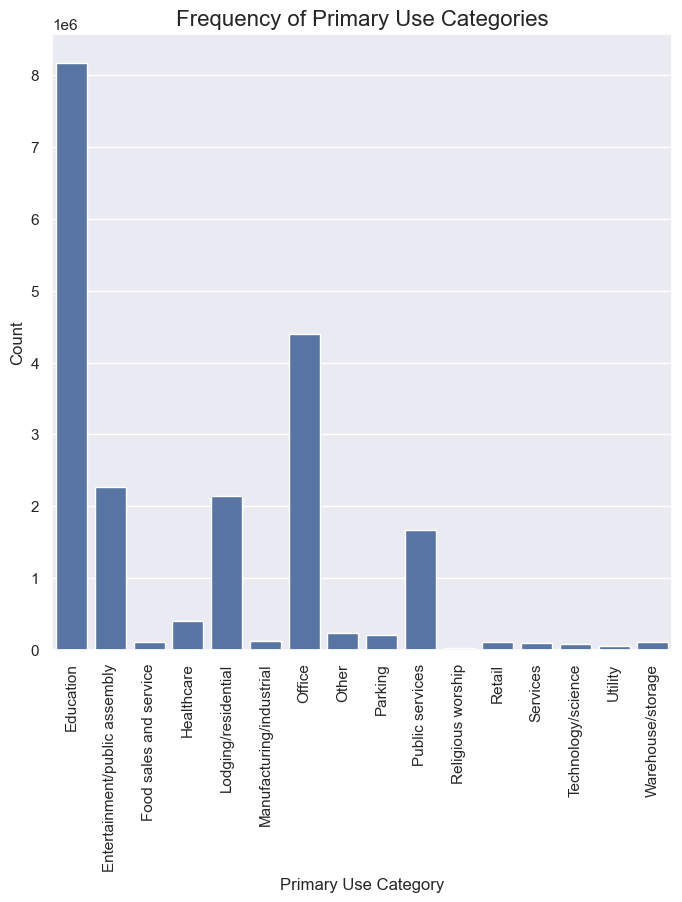

In [32]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'primary_use', data = train).set_title("Frequency of Primary Use Categories", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Primary Use Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

**Observations:**
1. Educational buildings contribute the largest number of readings. 
2. Religious worships contribute the least readings.

## 4.4 Exploring Average Meter Reading Per Site and Use Category

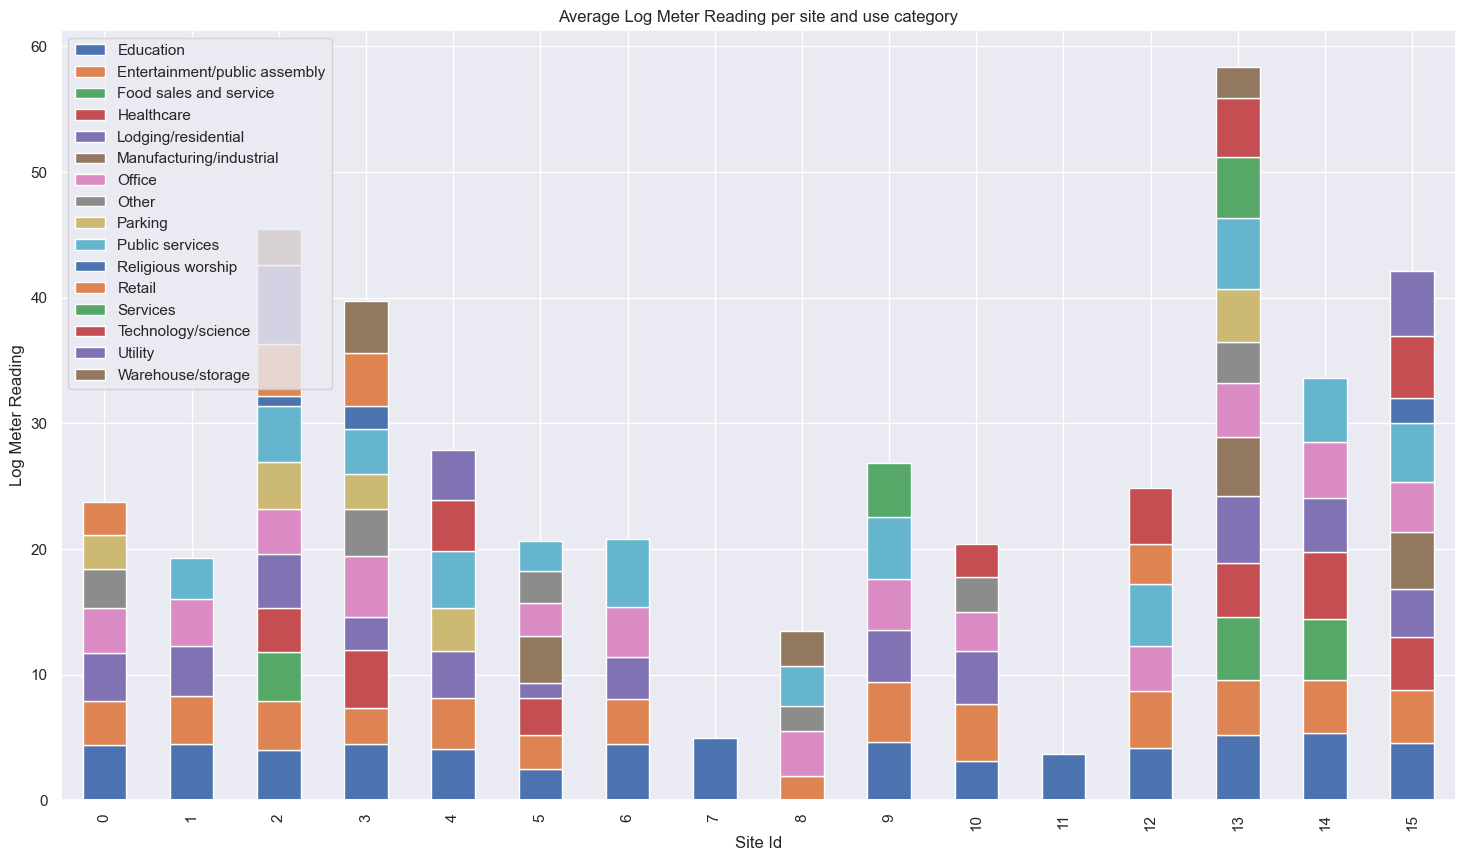

In [33]:
site_use_grouping = train.groupby(['site_id','primary_use'])['meter_reading'].mean().unstack('primary_use')
site_use_grouping.plot(kind = 'bar', stacked = True, figsize=(18,10)).set_title("Average Log Meter Reading per site and use category")
plt.xlabel('Site Id')
plt.ylabel('Log Meter Reading')
plt.legend(loc = "upper left")
plt.show()

**Observations:**
1. Site 13 has the highest average meter readings.
2. Site 11 has the least average meter readings and buildings in this site are primarily used as educational institutions.

## 4.5 Exploring Average Readings per Hour and Month

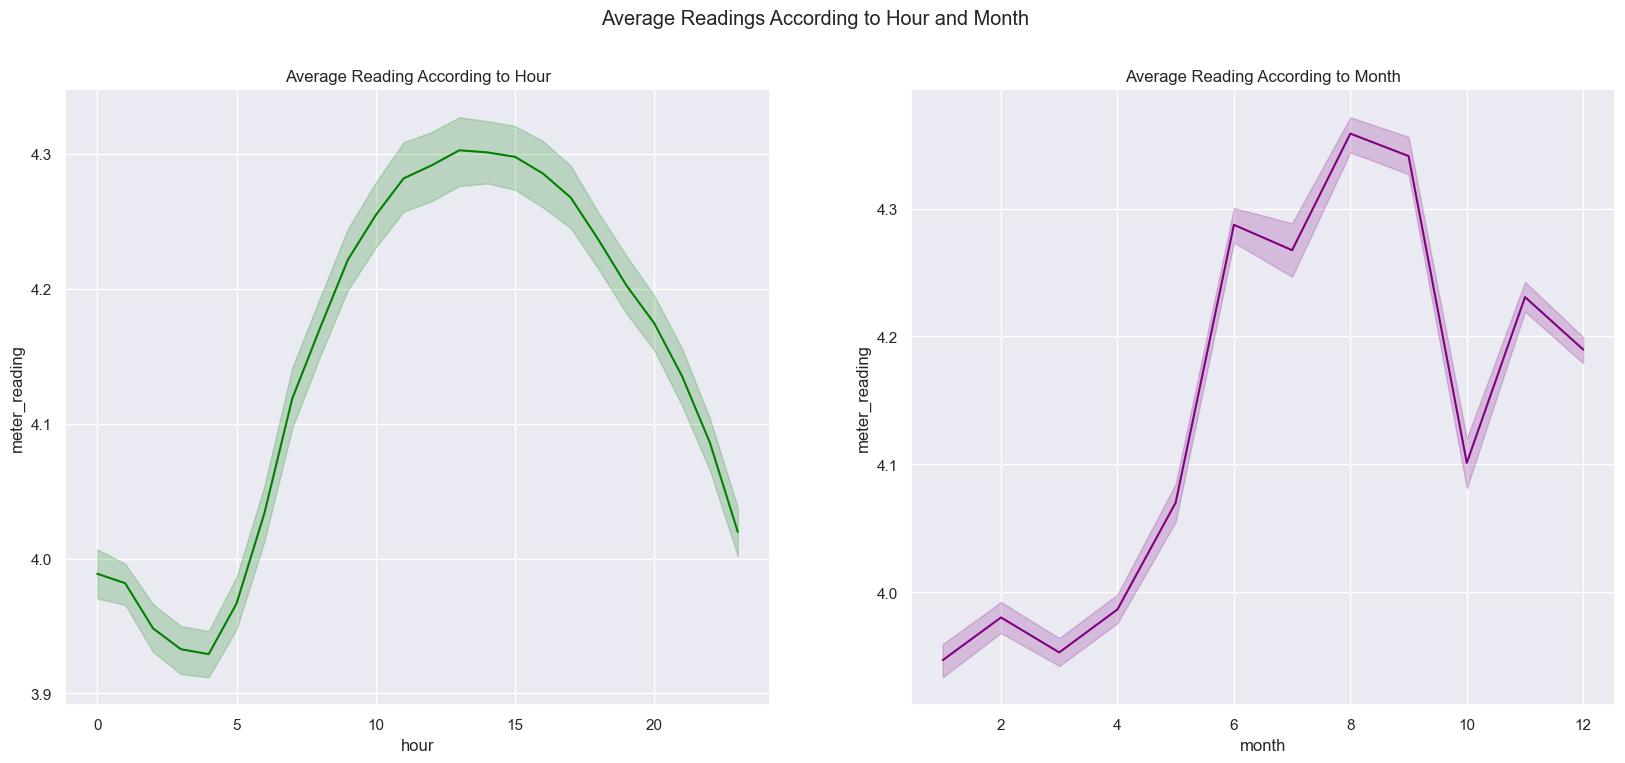

In [34]:
hour_groups = train.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
month_groups = train.groupby(['timestamp','month']).meter_reading.mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Average Readings According to Hour and Month')

sns.lineplot(x = hour_groups['hour'], y = hour_groups['meter_reading'], color='green', ax = ax1)
ax1.set_title('Average Reading According to Hour')


sns.lineplot(x = month_groups['month'], y = month_groups['meter_reading'], color='purple', ax = ax2)
ax2.set_title('Average Reading According to Month')

plt.show()

**Observations:**
1. Energy consumption drops in the early hours of the morning around 3-4am and rises again after 5am.
2. The hourly usage is maximized in the duration of 12-3pm, peeking at 1 in the afternoon which is a logical conclusion as many instituitions work around this period.
3. Energy Consumption is minimal during the period of January to March, reaching its lowest in March.
4. Consumption starts rising gradually from April and reaches a peek in August.


##  4.6 Exploring Average Readings per Building

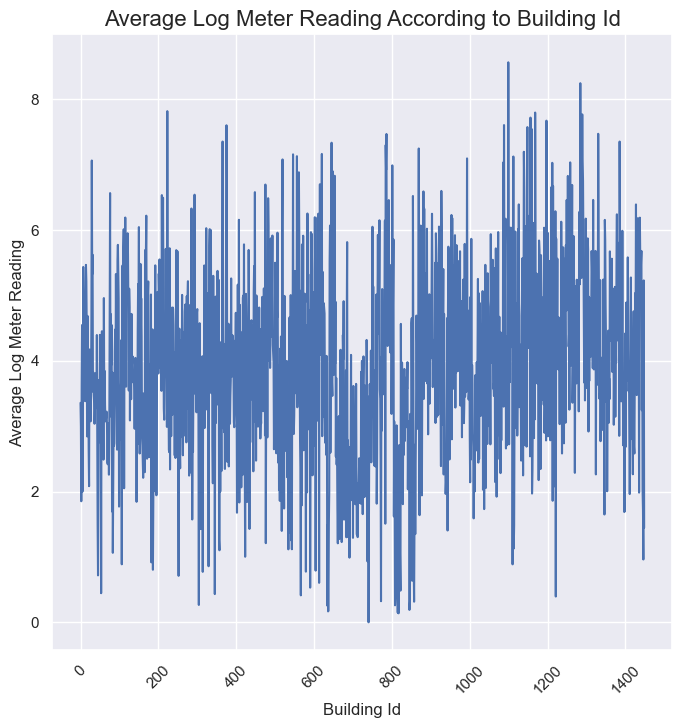

In [35]:
building_groups = train.groupby(['building_id']).meter_reading.mean().reset_index()

plt.figure(figsize=(8,8))
sns.lineplot(x = building_groups['building_id'], y = building_groups.meter_reading).set_title("Average Log Meter Reading According to Building Id", fontsize=16)
plt.xlabel('Building Id', fontsize=12)
plt.ylabel('Average Log Meter Reading', fontsize=12)
plt.xticks(rotation=45)
plt.show()

##  4.7 Checking Missing Values

In [36]:
missing_values = pd.DataFrame(train.isnull().sum() * 100 / len(train))
missing_values.columns = ["Missing Values"]

missing_values = missing_values[missing_values["Missing Values"] != 0]
missing_values.sort_values(by = "Missing Values", axis = 0, ascending = False, inplace = True)

missing_values

,Missing Values
floor_count,82.652772
year_built,59.990033
cloud_coverage,43.655131
precip_depth_1_hr,18.544739
wind_direction,7.167792
sea_level_pressure,6.092515
wind_speed,0.710701
dew_temperature,0.495348
air_temperature,0.478124


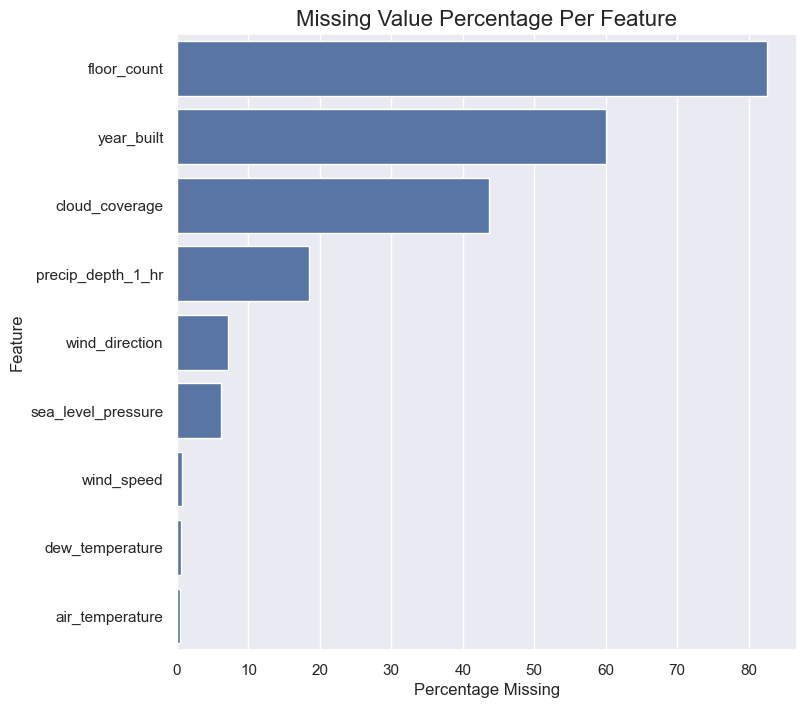

In [37]:
plt.figure(figsize=(8,8))
sns.barplot(x = missing_values['Missing Values'], y = missing_values.index).set_title("Missing Value Percentage Per Feature", fontsize=16)
plt.xlabel('Percentage Missing', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

**Observations:**
1. Floor count has the highest number of missing values, with a percentage reaching 82.6 %.
2. Year Built is the second leading column in missing values with almost 60% of the data being null.
3. This needs to be taken care of during the data preparation process before feeding it to the models for training.

## 4.8 Visualizing Correlation Between the Different Features 

In [38]:
correlation_matrix = train.select_dtypes(include=['number']).corr()

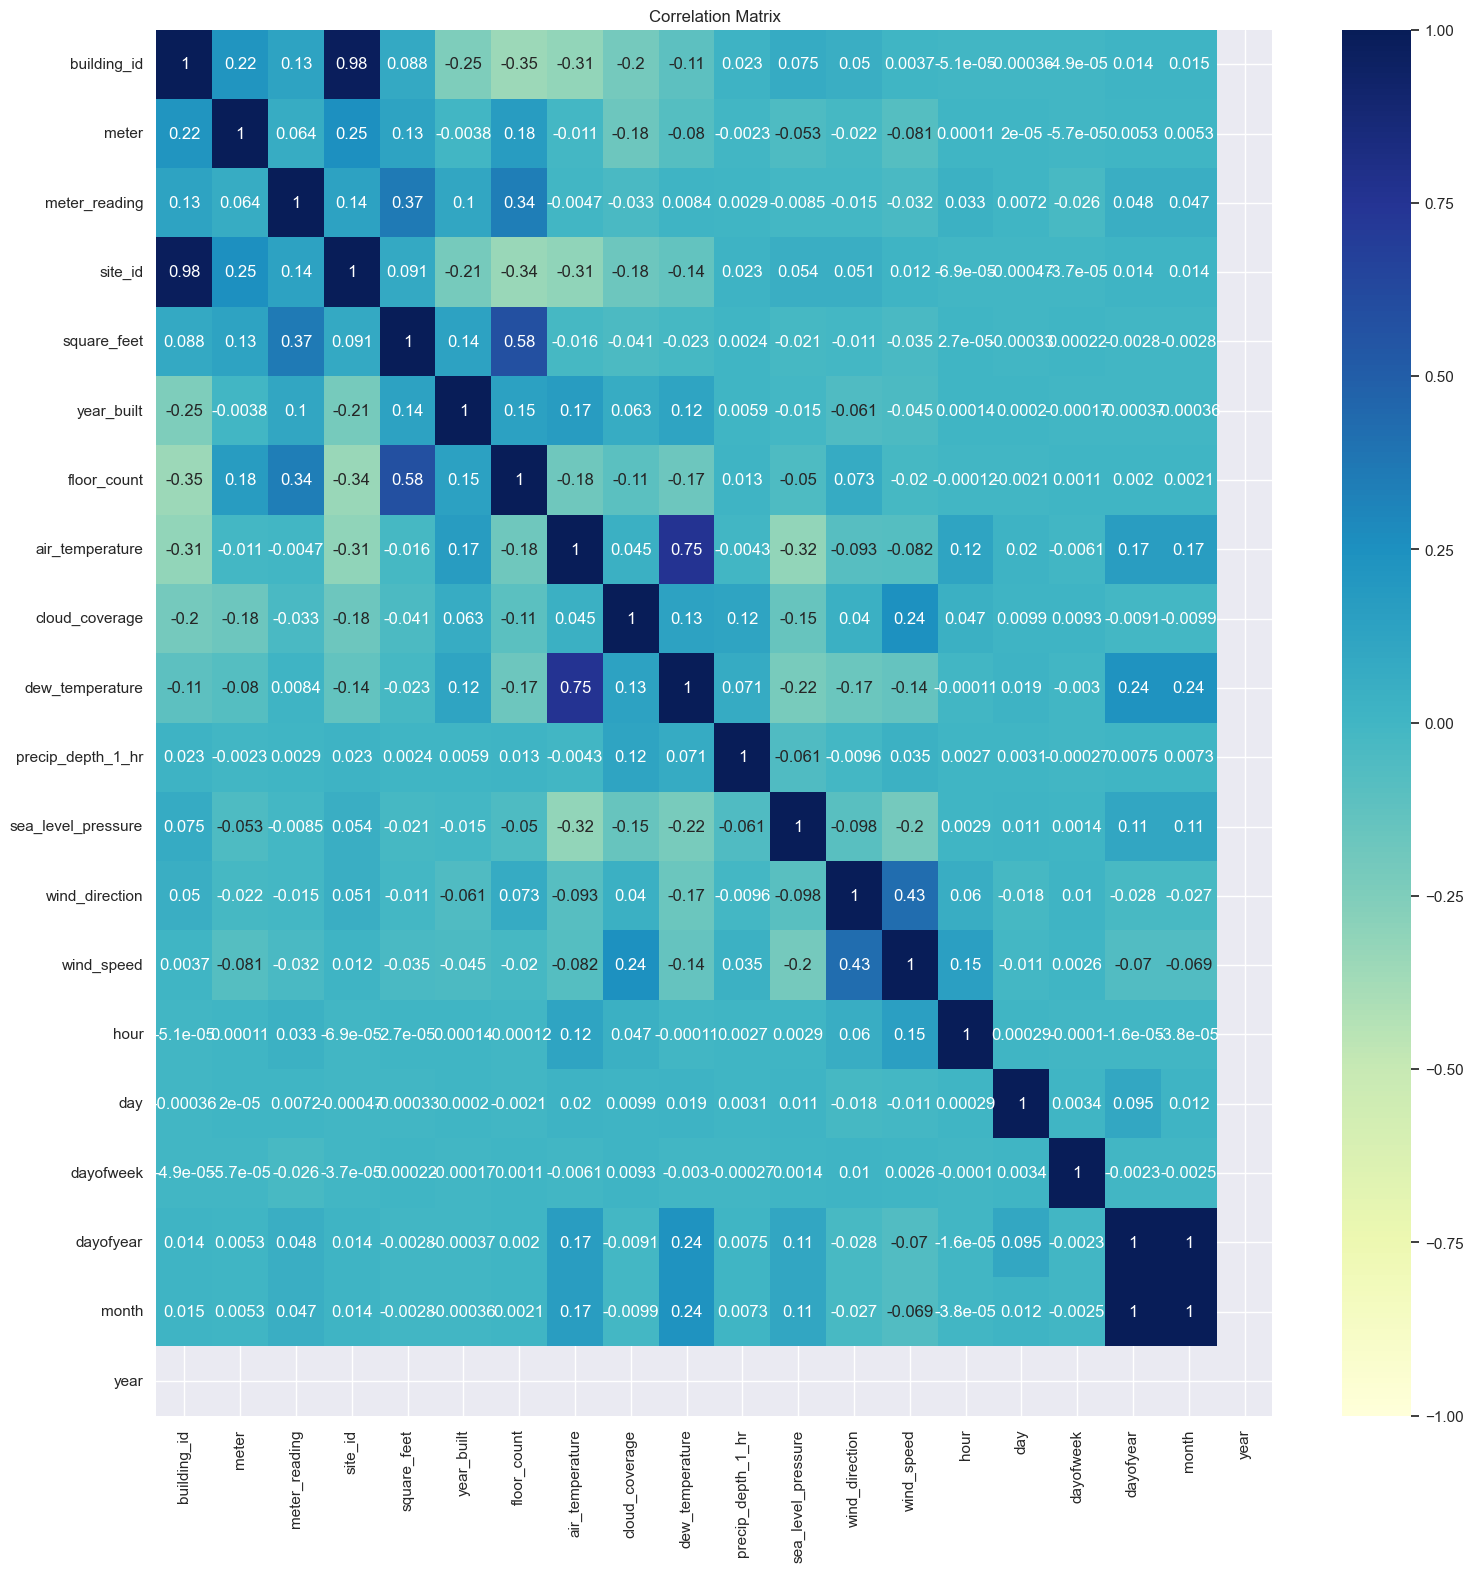

In [39]:
plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [40]:
target_corr_df = pd.DataFrame(correlation_matrix["meter_reading"].sort_values(ascending=False))
target_corr_df 

,meter_reading
meter_reading,1.000000
square_feet,0.366016
floor_count,0.342052
site_id,0.139902
building_id,0.126395
year_built,0.103332
meter,0.064360
dayofyear,0.047776
month,0.047386
hour,0.033277


**Observations:**
1. Site Id is extremely correlated with the Building Id (Correlation of 1).
2. Dew Temperature and Air Temperature have the second highest correlation, with a correlation of 0.8.
3. No features have a strong correlation with the target value 'Meter Reading'.

## 4.9  Visualizing Features Histograms

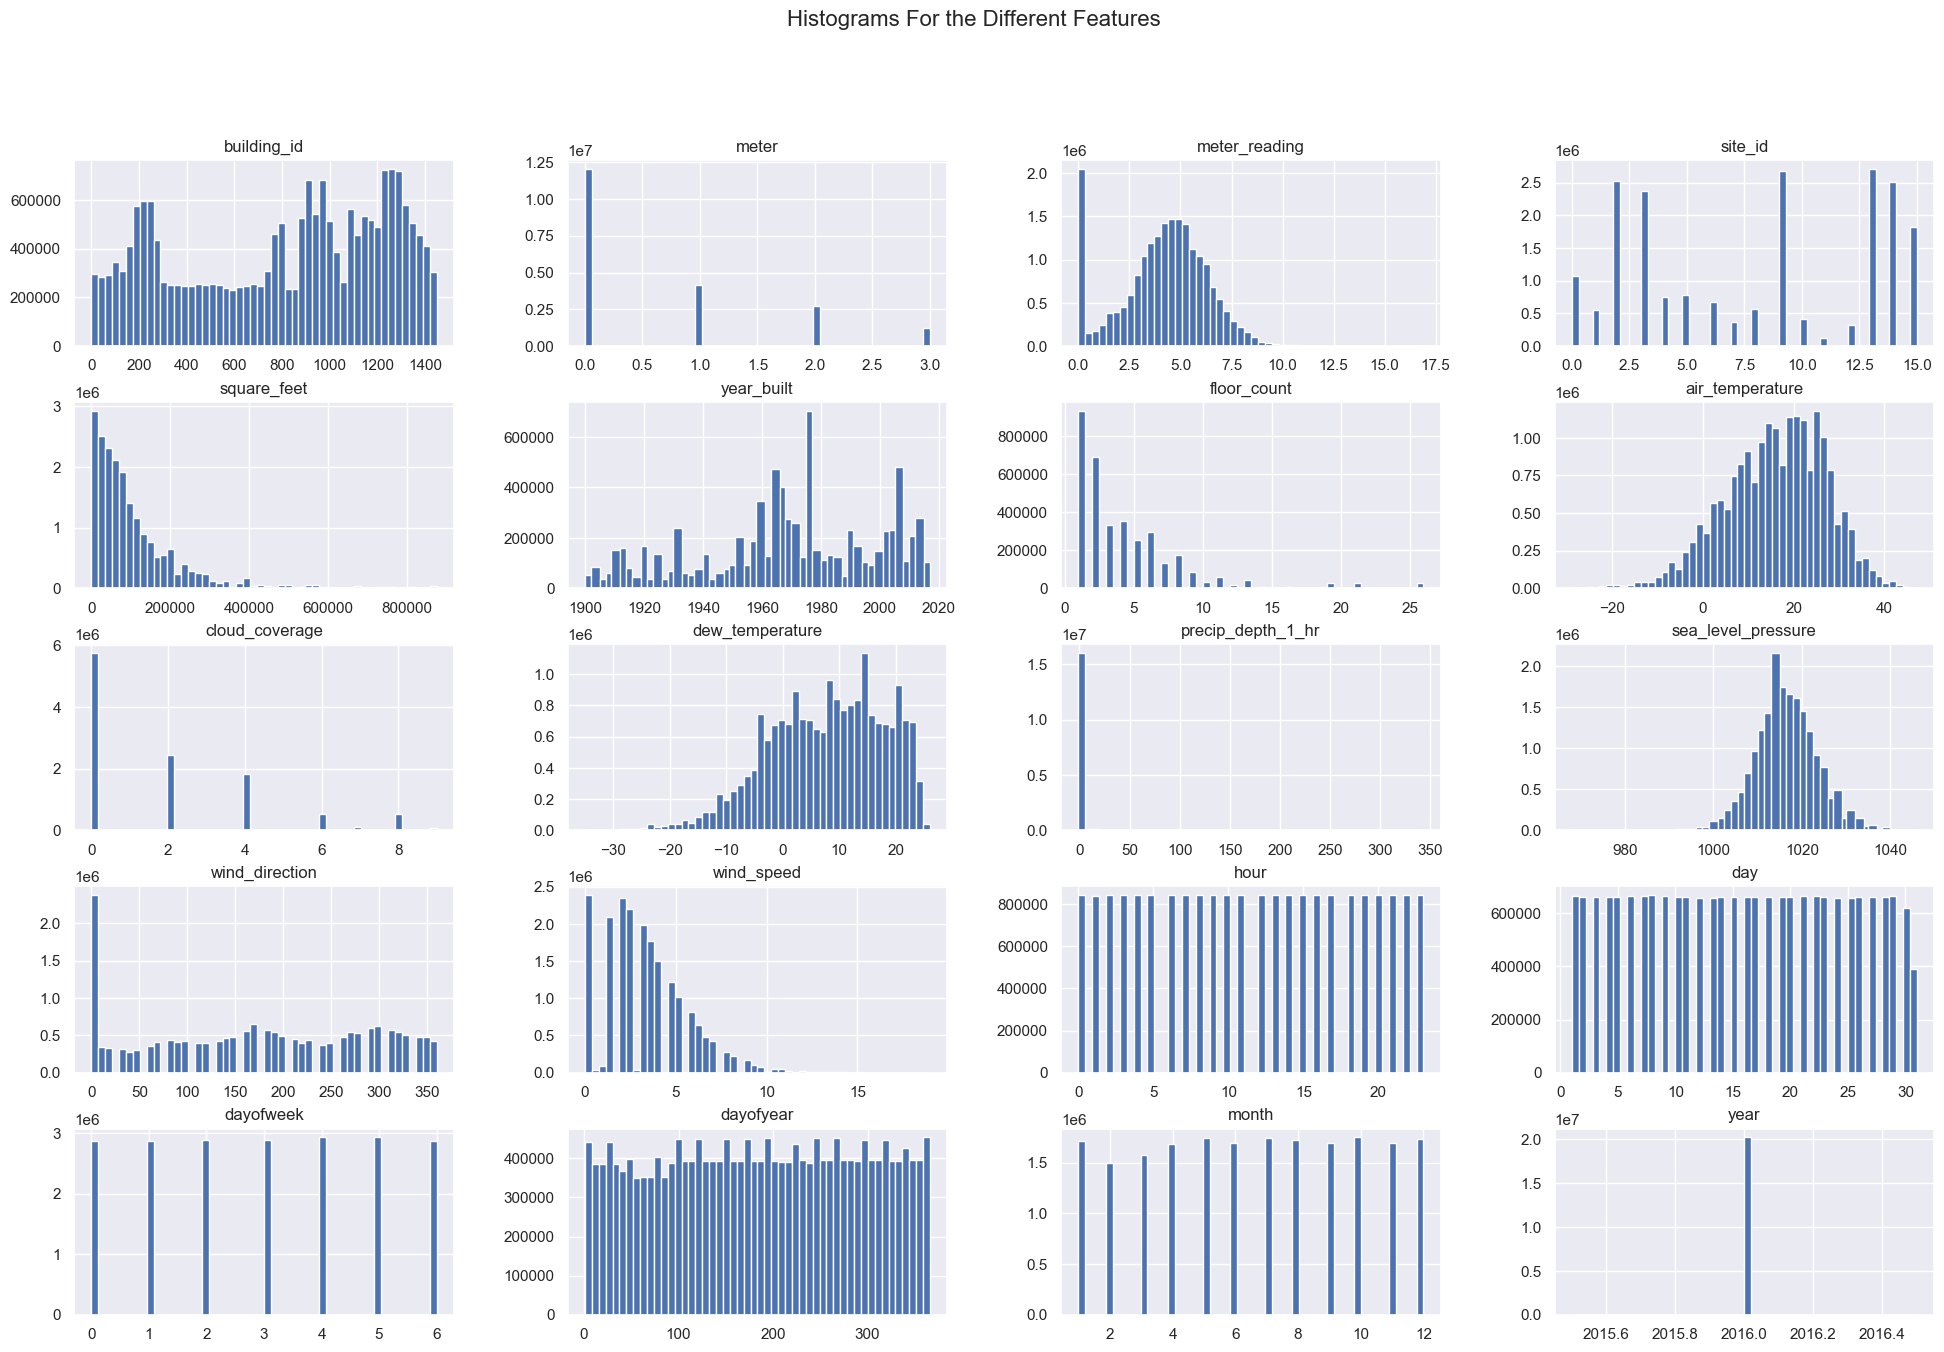

In [41]:
train.hist(bins=50, figsize=(24,15))
plt.suptitle('Histograms For the Different Features', fontsize=16)
plt.show()

**Observations:**
- Square Feet is heavily skewed to the left, therefore, we need to apply log transformation to fix that.

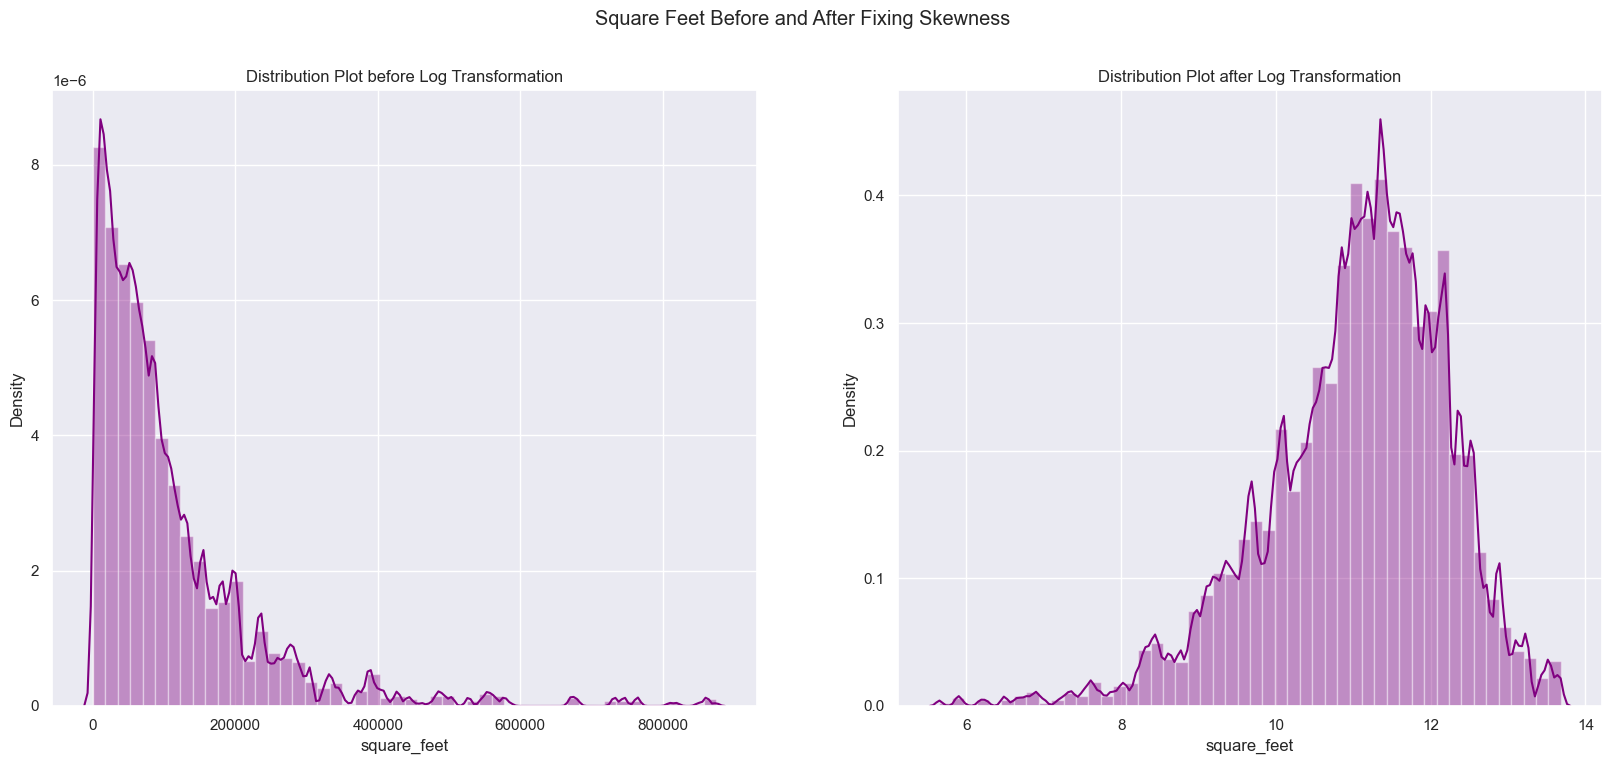

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Square Feet Before and After Fixing Skewness')

sns.distplot(train['square_feet'], color='purple', ax = ax1)
ax1.set_title('Distribution Plot before Log Transformation')

sns.distplot(np.log1p(train['square_feet']), color='purple', ax = ax2)
ax2.set_title('Distribution Plot after Log Transformation')

plt.show()

In [43]:
print('Square Feet skewness before Log Transformation is: ', train['square_feet'].skew())

train['square_feet'] = np.log1p(train['square_feet'])
print('Square Feet skewness after Log Transformation is: ', train['square_feet'].skew())

Square Feet skewness before Log Transformation is:  2.6664165857123243
Square Feet skewness after Log Transformation is:  -0.7811655719213683
